In [1]:
import numpy as np


class ReLU():
    def forward(self, x):
        return np.maximum(0, x)
    
class Sigmiod:
    def forward(self, x):
        return 1 / (1 + np.exp(-x))


class DenseLayer():
    def __init__(self, units, activation):
        self.units = units
        self.activation = activation
        self.weights = None
        self.bias = None
    
    def initialize(self, input_dim):
        self.weights = np.random.randn(input_dim, self.units) * 0.1
        self.bias = np.zeros((1, self.units))
    
    def forward(self, x):
        return self.activation.forward(np.dot(x, self.weights) + self.bias)
    
    def get_weights(self):
        return np.concatenate([self.weights.flatten(), self.bias.flatten()])
    
    def set_weights(self, weights):
        weights_count = self.weights.size
        self.weights = weights[:weights_count].reshape(self.weights.shape)
        self.bias = weights[weights_count:].reshape(self.bias.shape)

class GeneticOptimizer:
    def __init__(self, population_size = 150, mutation_rate = 0.1):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        
    def optimize(self, model, X, y, loss_fn, epochs):
        # Отримуємо розмір генома (всі ваги мережі)
        weights_shape = len(model.get_weights())
        
        # Ініціалізуємо популяцію
        population = [np.random.randn(weights_shape) * 0.1 for _ in range(self.population_size)]
        
        history = []
        
        for epoch in range(epochs):
            # Оцінюємо кожну особину в популяції
            fitness_scores = []
            for weights in population:
                model.set_weights(weights)
                predictions = model.predict(X)
                loss = loss_fn(y, predictions)
                fitness_scores.append(1 / (loss + 1e-10))  # Перетворюємо loss у fitness
            
            # Нормалізуємо fitness scores
            fitness_scores = np.array(fitness_scores)
            fitness_scores = fitness_scores / fitness_scores.sum()
            
            # Зберігаємо найкращу особину
            best_idx = np.argmax(fitness_scores)
            best_loss = 1 / fitness_scores[best_idx] - 1e-10
            history.append(best_loss)
            
            # Вибираємо батьків для наступного покоління
            new_population = []
            for _ in range(self.population_size):
                # Вибираємо двох батьків
                parents = np.random.choice(len(population), 2, p=fitness_scores)
                parent1, parent2 = population[parents[0]], population[parents[1]]
                
                # Схрещування (crossover)
                child = np.zeros_like(parent1)
                mask = np.random.random(len(parent1)) < 0.5
                child[mask] = parent1[mask]
                child[~mask] = parent2[~mask]
                
                # Мутація
                mutation_mask = np.random.random(len(child)) < self.mutation_rate
                child[mutation_mask] += np.random.randn(mutation_mask.sum()) * 0.1
                
                new_population.append(child)
            
            population = new_population
            
            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Loss: {best_loss:.4f}")
        
        # Встановлюємо найкращі знайдені ваги
        best_weights = population[np.argmax(fitness_scores)]
        model.set_weights(best_weights)
        
        return history

class MSE:
    def __call__(self, y_true, y_pred) -> float:
        return np.mean((y_true - y_pred) ** 2)

class NeuralNetwork:
    def __init__(self, input_dim):
        self.input_dim = input_dim
        self.layers = []
        
    def add_layer(self, layer):
        input_dim = self.input_dim if not self.layers else self.layers[-1].units
        layer.initialize(input_dim)
        self.layers.append(layer)
    
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def predict(self, x):
        return self.forward(x)
    
    def get_weights(self):
        weights = []
        for layer in self.layers:
            weights.extend(layer.get_weights())
        return np.array(weights)
    
    def set_weights(self, weights):
        start = 0
        for layer in self.layers:
            layer_weights = layer.get_weights()
            layer.set_weights(weights[start:start + len(layer_weights)])
            start += len(layer_weights)
    
    def fit(self, X, y, epochs = 1000, optimizer=GeneticOptimizer(), loss_fn=MSE()):      
        return optimizer.optimize(self, X, y, loss_fn, epochs)

In [2]:
import pandas as pd
import statsmodels.api as sm

df = sm.datasets.macrodata.load_pandas().data

# Функція для створення дати з року та кварталу
def create_date(row):
    return pd.Timestamp(year=int(row['year']), month=int(row['quarter'] * 3 - 2), day=1)

df['date'] = df.apply(create_date, axis=1)
year = df.drop_duplicates("year")
year = df

X = year[['realgdp', 'realcons', 'realinv', 'realgovt',
        'realdpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']].values
# X = df[['realgdp', 'realcons', 'realinv', 'realgovt']].values 
y = year['cpi'].values  # Цільова змінна

In [3]:

y = y.reshape(-1, 1)
# Створюємо модель
model = NeuralNetwork(X.shape[1])
model.add_layer(DenseLayer(8, ReLU()))
model.add_layer(DenseLayer(1, ReLU()))

# Навчаємо модель
history = model.fit(X, y, epochs=1000, optimizer=GeneticOptimizer())

# Тестуємо модель
predictions = model.predict(X)
mse = MSE()(y, predictions)
print(f"Final MSE: {mse:.4f}")

Epoch 100/1000, Loss: 58.2133
Epoch 200/1000, Loss: 54.0765
Epoch 300/1000, Loss: 59.1447
Epoch 400/1000, Loss: 55.1936
Epoch 500/1000, Loss: 51.4356
Epoch 600/1000, Loss: 56.8221
Epoch 700/1000, Loss: 63.4932
Epoch 800/1000, Loss: 66.5432
Epoch 900/1000, Loss: 58.1230
Epoch 1000/1000, Loss: 63.1449
Final MSE: 54.3467


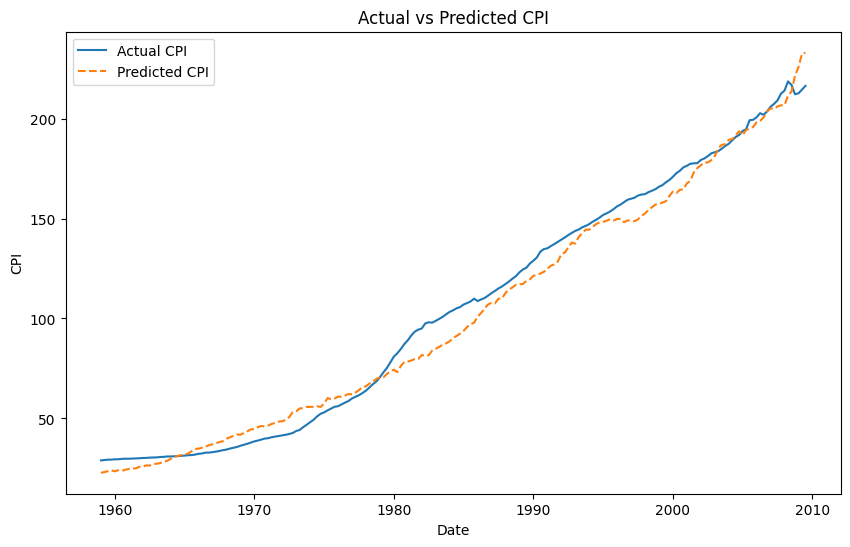

In [4]:
import matplotlib.pyplot as plt

# Прогнозні дані
predicted_output = model.forward(X)

# Створення графіку
plt.figure(figsize=(10, 6))
plt.plot(year['date'], y, label='Actual CPI')
plt.plot(year['date'], predicted_output, label='Predicted CPI', linestyle='--')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.title('Actual vs Predicted CPI')
plt.legend()
plt.show()

Training on window 1 (0-50)
Epoch 100/1000, Loss: 146.9644
Epoch 200/1000, Loss: 145.4017
Epoch 300/1000, Loss: 143.8603
Epoch 400/1000, Loss: 140.4559
Epoch 500/1000, Loss: 134.4869
Epoch 600/1000, Loss: 133.5806
Epoch 700/1000, Loss: 127.9042
Epoch 800/1000, Loss: 130.0458
Epoch 900/1000, Loss: 127.8081
Epoch 1000/1000, Loss: 120.7332


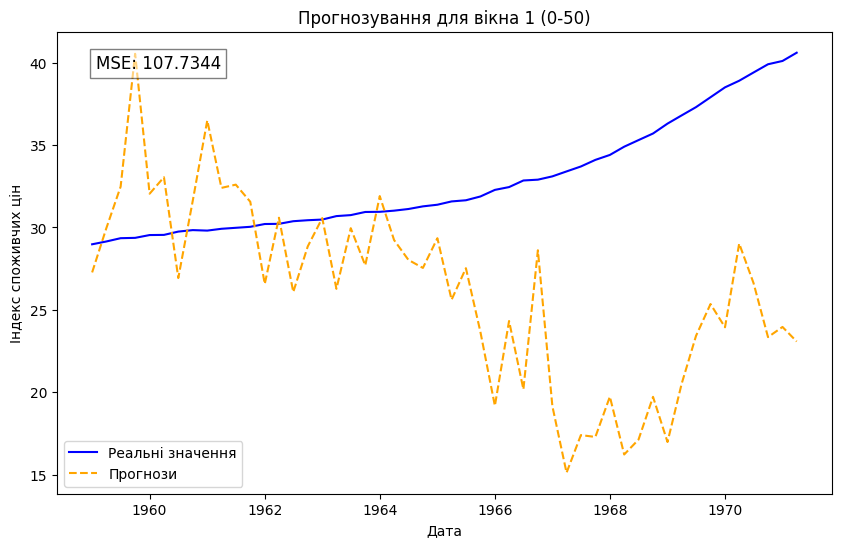

Training on window 2 (1-51)
Epoch 100/1000, Loss: 147.0007
Epoch 200/1000, Loss: 145.3252
Epoch 300/1000, Loss: 139.7386
Epoch 400/1000, Loss: 129.1528
Epoch 500/1000, Loss: 129.0717
Epoch 600/1000, Loss: 113.9798
Epoch 700/1000, Loss: 126.4738
Epoch 800/1000, Loss: 109.0138
Epoch 900/1000, Loss: 112.8762
Epoch 1000/1000, Loss: 98.1840


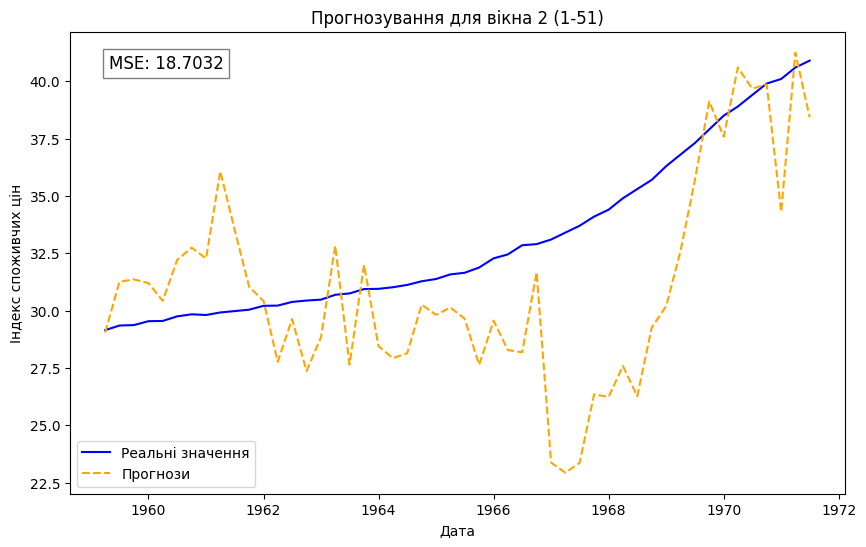

Training on window 3 (2-52)
Epoch 100/1000, Loss: 148.5753
Epoch 200/1000, Loss: 144.6490
Epoch 300/1000, Loss: 141.2901
Epoch 400/1000, Loss: 137.2185
Epoch 500/1000, Loss: 127.9107
Epoch 600/1000, Loss: 131.8446
Epoch 700/1000, Loss: 122.5693
Epoch 800/1000, Loss: 120.0259
Epoch 900/1000, Loss: 112.8931
Epoch 1000/1000, Loss: 121.3097


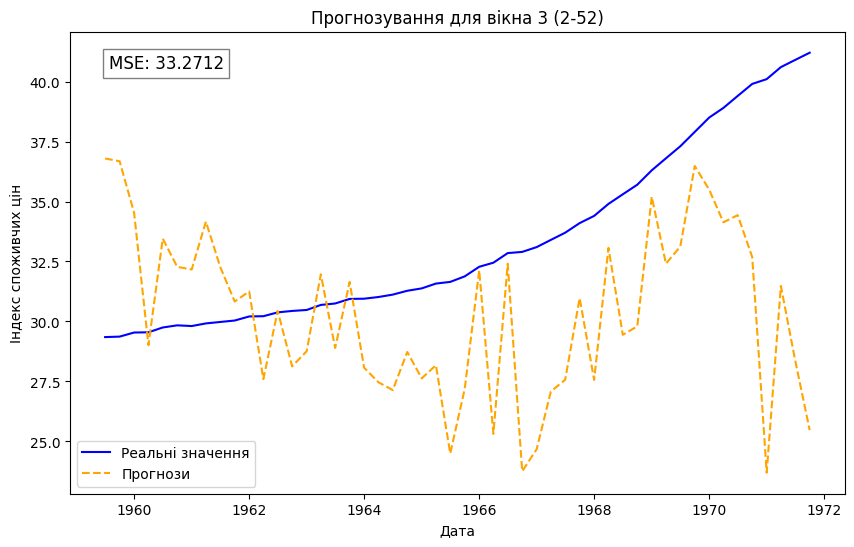

In [5]:
def sliding_window_training(X, y, window_size=12, num_windows=10): 
    for window in range(num_windows):  # Цикл для всіх вікон
        start_index = window
        end_index = start_index + window_size
        
        # if end_index > n_samples:
        #     break  # Вихід, якщо виходимо за межі даних
        
        print(f"Training on window {window + 1} ({start_index}-{end_index})")
        
        X_window = X[start_index:end_index] 
        y_window = y[start_index:end_index]

        # Навчання мережі на поточному вікні
        model.fit(X, y, epochs=1000, optimizer=GeneticOptimizer())
        # Прогнозування 
        predictions = model.forward(X_window)

        # Розрахунок DELTA та DELTA^2
        delta = predictions.flatten() - y_window.flatten()
        delta_squared = delta ** 2
        
        # Підготовка даних для таблиці
        results_df = pd.DataFrame({
            'Point': np.arange(window_size)[::-1],
            'IPC RO': y_window.flatten(),
            'IPC PO': predictions.flatten(),
            'DELTA': delta,
            'DELTA^2': delta_squared
        })
        
        # Обчислення TOTAL та MSE
        total_delta = delta.sum()
        total_delta_squared = delta_squared.sum()
        mse = np.mean(delta_squared)

        # Додавання підсумків до таблиці
        results_df.loc[len(results_df)] = ['TOTAL', '', total_delta, '', total_delta_squared]
        results_df.loc[len(results_df)] = ['MSE', '', '', '', mse]

        # Збереження результатів у Excel
        results_df.to_excel(f'full/sliding_window_results_window_{window + 1}.xlsx', index=False)

        # Візуалізація
        plt.figure(figsize=(10, 6))
        plt.plot(df['date'][start_index:end_index], y_window, label='Реальні значення', color='blue')
        plt.plot(df['date'][start_index:end_index], predictions, label='Прогнози', linestyle='--', color='orange')
        plt.xlabel('Дата')
        plt.ylabel('Індекс споживчих цін')
        plt.title(f'Прогнозування для вікна {window + 1} ({start_index}-{end_index})')
        plt.legend()

        plt.text(0.05, 0.95, f'MSE: {mse:.4f}', transform=plt.gca().transAxes,
                 fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

        plt.savefig(f'full/window_{window + 1}_forecast.png')  # Зберігаємо графік
        plt.show()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
sliding_window_training(X, y, window_size=50, num_windows=3)